In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

import time


In [2]:
# load in the GG SNR ratio stars
file_name = '-test-rgbs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-test-GGsnr/'
file_path = '../data/master-APOGEE-giants-test-GGsnr.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

test_ID = label_data['ids']
test_flux = spectra_data['fluxes']
test_flux_err = spectra_data['fluxes_err']
test_flux_ivar = spectra_data['fluxes_ivars']
test_label = label_data['labels']
test_label_err = label_data['labels_err']
test_label_ivar = label_data['labels_ivars']

../spec/spectra-reference-stars-APOGEE-giants-test-GGsnr/spectra_data-test-rgbs.dat
File already exists. Loading spectra data


24it [00:00, 76.69it/s]

Loaded data successfully


In [3]:
# do the same for the other low SNR sample
file_name = '-test-rgbs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-test-lowsnr/'
file_path = '../data/master-APOGEE-giants-test-lowsnr.fits'
spectra_data_v2, label_data_v2 = ld.load_data(spectra_dir_path, file_path, file_name)

test_ID_v2 = label_data_v2['ids']
test_flux_v2 = spectra_data_v2['fluxes']
test_flux_err_v2 = spectra_data_v2['fluxes_err']
test_flux_ivar_v2 = spectra_data_v2['fluxes_ivars']
test_label_v2 = label_data_v2['labels']
test_label_err_v2 = label_data_v2['labels_err']
test_label_ivar_v2 = label_data_v2['labels_ivars']

../spec/spectra-reference-stars-APOGEE-giants-test-lowsnr/spectra_data-test-rgbs.dat
File already exists. Loading spectra data


24it [00:00, 111.97it/s]

Loaded data successfully


In [4]:
file_name = '-test-rgbs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-10K-ref/'
file_path = '../data/master-APOGEE-giants-test.fits'
spectra_data_highsnr, label_data_highsnr = ld.load_data(spectra_dir_path, file_path, file_name)

test_ID_highsnr = label_data_highsnr['ids']
test_flux_highsnr = spectra_data_highsnr['fluxes']
test_flux_err_highsnr = spectra_data_highsnr['fluxes_err']
test_flux_ivar_highsnr = spectra_data_highsnr['fluxes_ivars']
test_label_highsnr = label_data_highsnr['labels']
test_label_err_highsnr = label_data_highsnr['labels_err']
test_label_ivar_highsnr = label_data_highsnr['labels_ivars']

../spec/spectra-reference-stars-APOGEE-giants-10K-ref/spectra_data-test-rgbs.dat
File already exists. Loading spectra data


24it [00:00, 54.51it/s]

Loaded data successfully


In [10]:
snr_tot = []
snr_tot.extend(label_data['snr'])
snr_tot.extend(label_data_v2['snr'])
snr_tot.extend(label_data_highsnr['snr'])
snr_tot = np.array(snr_tot)

flux_tot = np.concatenate((test_flux, test_flux_v2, test_flux_highsnr))
flux_tot_err = np.concatenate((test_flux_err, test_flux_err_v2, test_flux_err_highsnr))
flux_tot_ivar = np.concatenate((test_flux_ivar, test_flux_ivar_v2, test_flux_ivar_highsnr))

label_tot = np.concatenate((test_label, test_label_v2, test_label_highsnr))
label_tot_err = np.concatenate((test_label_err, test_label_err_v2, test_label_err_highsnr))
label_tot_ivar = np.concatenate((test_label_ivar, test_label_ivar_v2, test_label_ivar_highsnr))

snr_tot.shape, flux_tot_err.shape


((18000,), (18000, 8575))

In [11]:
mask_snr = (snr_tot>20) &(snr_tot<300) 
print(len(snr_tot[mask_snr]))

14870


In [11]:
# we will first subsample randomly for computational convenience
N_samp = 2000
indices = np.arange(len(snr_tot[mask_snr]))
ran_in = np.random.choice(indices, N_samp, replace=False)

flux_tot_samp = flux_tot[mask_snr,:][ran_in,:]
flux_tot_err_samp = flux_tot_err[mask_snr,:][ran_in,:]
flux_tot_ivar_samp = flux_tot_ivar[mask_snr,:][ran_in,:]

label_tot_samp = label_tot[mask_snr,:][ran_in,:]
label_tot_err_samp = label_tot_err[mask_snr,:][ran_in,:]
label_tot_ivar_samp = label_tot_ivar[mask_snr,:][ran_in,:]

snr_tot_samp = snr_tot[mask_snr][ran_in]

Sample within the error of the flux to get samples of the flux.

NOTE: This should be equivalent to computing the inverse of the Fisher information matrix on parameters zeta, and then using that to get uncertainties on the labels

In [19]:
n_samples = 10

flux_tot_sampled = np.zeros((flux_tot_samp.shape[0],flux_tot_samp.shape[1], n_samples))

for indx, i in tqdm.tqdm_notebook(enumerate(flux_tot_samp)):
    for jndx, j in enumerate(i):
        if j !=1:
            flux_tot_sampled[indx, jndx] = np.random.normal(j, flux_tot_err_samp[indx][jndx], n_samples)
        else:
            flux_tot_sampled[indx, jndx] = np.tile(j, n_samples)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_30223/3136878475.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(flux_tot_samp)):


0it [00:00, ?it/s]

In [22]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-highsnrgiants'
alphas = np.load(savepath+'alphas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
betas = np.load(savepath+'betas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
zetas = np.load(savepath+'zetas_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
ln_noise_fluxes_updated = jnp.log(np.load(savepath+'noise_fluxes_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True))


In [25]:
# first using the fluxes
P = 49
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(label_tot_samp, flux_tot_samp, P)
zetas_init_test.shape

(2000, 49)

In [27]:
zetas_all_sampled = []

for indx, i in tqdm.tqdm_notebook(enumerate(flux_tot_sampled.T)):
    z_ = opt_sc.get_zetas_test_using_fluxes(i.T, flux_tot_ivar_samp2, betas, zetas_init_test, ln_noise_fluxes_updated)
    zetas_all_sampled.append(z_)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_30223/3131307597.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(flux_tot_sampled.T)):


0it [00:00, ?it/s]

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 508095793811.523, Curvature error: 5.4562735507809306e+17
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 507668969419.85205, Curvature error: 5.451690283587368e+17
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 505504642915.0355, Curvature error: 5.428450847784626e+17
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 503924763310.4396, Curvature error: 5.411485973202329e+17
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 501341259352.5879, Curvature error: 5.3837432388611245e+17
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 505885067307.18024, Curvature error: 5.432533958246507e+17
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 510016493849.21576, Curvature err

In [28]:
z_sampled = np.zeros((n_samples, zetas_all_sampled[0].params['zetas'].shape[0], zetas_all_sampled[0].params['zetas'].shape[1]))

for indx, i in enumerate(zetas_all_sampled):
    z_sampled[indx] = i.params['zetas']

In [29]:
labels_sampled = np.zeros((n_samples, label_tot_samp.shape[0], label_tot_samp.shape[1]))

for indx, i in enumerate(z_sampled):
    prod = i @ alphas.T
    labels_sampled[indx] = prod

In [38]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-allSNRsampled'
np.save('../sav/zetas_sampled'+str(name), z_sampled)
np.save('../sav/labels_sampled'+str(name), labels_sampled)
np.save('../sav/snr_samp'+str(name), snr_tot_samp)

In [14]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-allSNRsampled'
z_sampled = np.load('../sav/zetas_sampled'+str(name)+'.npy', allow_pickle=True)
labels_sampled = np.load('../sav/labels_sampled'+str(name)+'.npy', allow_pickle=True)
snr_tot_samp = np.load('../sav/snr_samp'+str(name)+'.npy',  allow_pickle=True)

In [6]:
labels_sampled.shape
scatters_labels = np.nanstd(labels_sampled, axis=0)

In [7]:
bins = np.linspace(0, 300, 11)
print(bins)
def running_median(xs, ys):
    running_median = np.zeros((len(bins[:-1]), 3))
    for indx, i in enumerate(bins[:-1]):
        mask = (xs>i)&(xs<bins[indx+1])
        running_median[indx] = np.percentile(ys[mask], [16,50,84])
    return bins, running_median

[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300.]


In [15]:
bins_, rm_teff = running_median(snr_tot_samp, scatters_labels[:,0])
bins_, rm_logg = running_median(snr_tot_samp, scatters_labels[:,1])
bins_, rm_feh = running_median(snr_tot_samp, scatters_labels[:,2])
bins_, rm_cfe = running_median(snr_tot_samp, scatters_labels[:,3])
bins_, rm_nfe = running_median(snr_tot_samp, scatters_labels[:,4])
bins_, rm_ofe = running_median(snr_tot_samp, scatters_labels[:,5])
bins_, rm_mgfe = running_median(snr_tot_samp, scatters_labels[:,6])
bins_, rm_alfe = running_median(snr_tot_samp, scatters_labels[:,7])
bins_, rm_sife = running_median(snr_tot_samp, scatters_labels[:,8])
bins_, rm_cafe = running_median(snr_tot_samp, scatters_labels[:,9])
bins_, rm_mnfe = running_median(snr_tot_samp, scatters_labels[:,10])
bins_, rm_nife = running_median(snr_tot_samp, scatters_labels[:,11])


In [16]:
delta_bin = (bins_[1] - bins_[0])/2
bin_centres = bins_ + delta_bin
bin_centres.shape, rm_teff.shape

((11,), (10, 3))

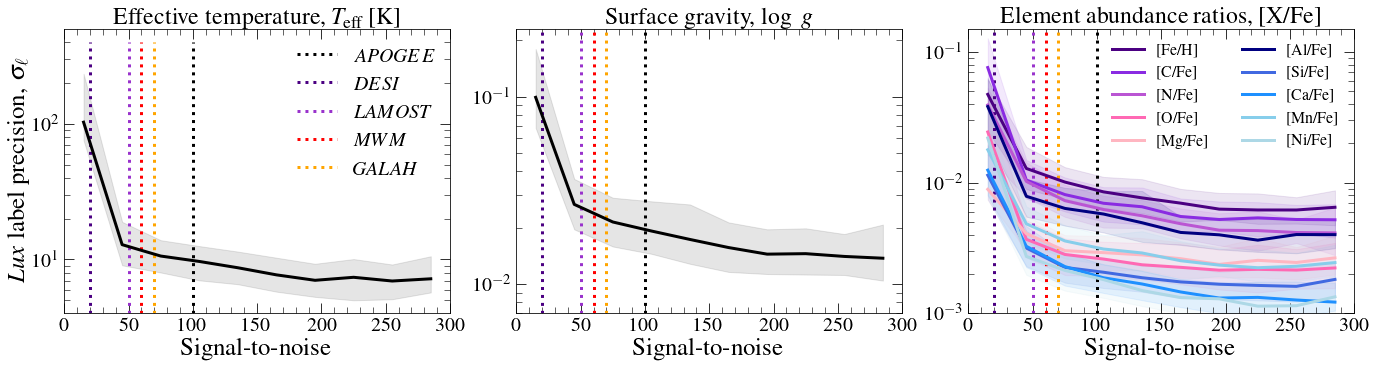

In [17]:
plt.figure(figsize=(19, 5), facecolor='white', constrained_layout=True)
plt.subplot(1,3,1)
plt.title('Effective temperature, $T_{\mathrm{eff}}$ [K]', fontsize=24)
plt.vlines(100,0,400, color='k', lw=3, ls='dotted', label='$APOGEE$')
plt.vlines(20,0,400, color='indigo', lw=3, ls='dotted', label='$DESI$')
plt.vlines(50,0,400, color='darkorchid', lw=3, ls='dotted', label='$LAMOST$')
plt.vlines(60,0,400, color='r', lw=3, ls='dotted', label='$MWM$')
plt.vlines(70,0,400, color='orange', lw=3, ls='dotted', label='$GALAH$')
plt.legend(loc='upper right', frameon=False, fontsize=20)
plt.plot(bin_centres[:-1], rm_teff[:,1], label='$T_{\mathrm{eff}}$', lw=3, color='k') 
plt.fill_between(bin_centres[:-1], rm_teff[:,0], rm_teff[:,2], alpha=0.1, color='k')
plt.xlabel('Signal-to-noise', fontsize=25)
plt.ylabel('$Lux$ label precision, $\sigma_{\ell}$', fontsize=25)
plt.xlim(0,300)
# plt.ylim(0,500)
plt.yscale('log')
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
plt.title('Surface gravity, $\log~g$', fontsize=24)
plt.vlines(100,0,400, color='k', lw=3, ls='dotted')
plt.vlines(20,0,400, color='indigo', lw=3, ls='dotted')
plt.vlines(50,0,400, color='darkorchid', lw=3, ls='dotted')
plt.vlines(60,0,400, color='r', lw=3, ls='dotted')
plt.vlines(70,0,400, color='orange', lw=3, ls='dotted')
plt.plot(bin_centres[:-1], rm_logg[:,1], label='$\log~g$', lw=3, color='k') 
plt.fill_between(bin_centres[:-1], rm_logg[:,0], rm_logg[:,2], alpha=0.1, color='k')
plt.xlabel('Signal-to-noise', fontsize=25)
plt.xlim(0,300)
plt.ylim(0.007,0.23)
plt.yscale('log')
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

colors = ['k', 'indigo', 'blueviolet', 'mediumorchid','hotpink','lightpink','navy','royalblue','dodgerblue', 'skyblue','lightblue', 'paleturquoise']
plt.subplot(1,3,3)
plt.title('Element abundance ratios, [X/Fe]', fontsize=24)
plt.vlines(100,0,400, color='k', lw=3, ls='dotted')
plt.vlines(20,0,400, color='indigo', lw=3, ls='dotted')
plt.vlines(50,0,400, color='darkorchid', lw=3, ls='dotted')
plt.vlines(60,0,400, color='r', lw=3, ls='dotted')
plt.vlines(70,0,400, color='orange', lw=3, ls='dotted')
plt.plot(bin_centres[:-1], rm_feh[:,1], label='[Fe/H]', lw=3, color=colors[1]) 
plt.fill_between(bin_centres[:-1], rm_feh[:,0], rm_feh[:,2], alpha=0.1, color=colors[1])
plt.plot(bin_centres[:-1], rm_cfe[:,1], label='[C/Fe]', lw=3, color=colors[2]) 
plt.fill_between(bin_centres[:-1], rm_cfe[:,0], rm_cfe[:,2], alpha=0.1, color=colors[2])
plt.plot(bin_centres[:-1], rm_nfe[:,1], label='[N/Fe]', lw=3, color=colors[3]) 
plt.fill_between(bin_centres[:-1], rm_nfe[:,0], rm_nfe[:,2], alpha=0.1, color=colors[3])
plt.plot(bin_centres[:-1], rm_ofe[:,1], label='[O/Fe]', lw=3, color=colors[4]) 
plt.fill_between(bin_centres[:-1], rm_ofe[:,0], rm_ofe[:,2], alpha=0.1, color=colors[4])
plt.plot(bin_centres[:-1], rm_mgfe[:,1], label='[Mg/Fe]', lw=3, color=colors[5]) 
plt.fill_between(bin_centres[:-1], rm_mgfe[:,0], rm_mgfe[:,2], alpha=0.1, color=colors[5])
plt.plot(bin_centres[:-1], rm_alfe[:,1], label='[Al/Fe]', lw=3, color=colors[6]) 
plt.fill_between(bin_centres[:-1], rm_alfe[:,0], rm_alfe[:,2], alpha=0.1, color=colors[6])
plt.plot(bin_centres[:-1], rm_sife[:,1], label='[Si/Fe]', lw=3, color=colors[7]) 
plt.fill_between(bin_centres[:-1], rm_sife[:,0], rm_sife[:,2], alpha=0.1, color=colors[7])
plt.plot(bin_centres[:-1], rm_cafe[:,1], label='[Ca/Fe]', lw=3, color=colors[8]) 
plt.fill_between(bin_centres[:-1], rm_cafe[:,0], rm_cafe[:,2], alpha=0.1, color=colors[8])
plt.plot(bin_centres[:-1], rm_mnfe[:,1], label='[Mn/Fe]', lw=3, color=colors[9]) 
plt.fill_between(bin_centres[:-1], rm_mnfe[:,0], rm_mnfe[:,2], alpha=0.1, color=colors[9])
plt.plot(bin_centres[:-1], rm_nife[:,1], label='[Ni/Fe]', lw=3, color=colors[10]) 
plt.fill_between(bin_centres[:-1], rm_nife[:,0], rm_nife[:,2], alpha=0.1, color=colors[10])
plt.xlim(0,300)
plt.ylim(0.001,0.15)
plt.yscale('log')
plt.xlabel('Signal-to-noise', fontsize=25)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=16)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/precision-snr-Lux.pdf',dpi=200, bbox_inches = 'tight')